<a href="https://colab.research.google.com/github/goulartsursula/DisciplinasUERJ/blob/master/Estrutura%20da%20Materia%203/EspectroscopiaGama.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Espectroscopia Gama

Disciplina: Estrutura da Matéria 3

Alunos: Danielle Lessa, Tayan Sequeira e Úrsula Goulart

In [171]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

| Isótopo | Meia-vida | Picos de emissão $\gamma$ de interesse |
| :-----: | :-------: | :------------------------------------: |
| Cs-137  | 30,2 anos | 662 keV                                |
| Co-60   | 5,27 anos | 1173/ 1333 keV                        |
| Na-22   | 2,60 anos | 511/ 1275 keV                         |

## Evento de Fundo

In [172]:
dataBack = pd.read_table('background.tsv', skiprows=22)



## Sódio 22

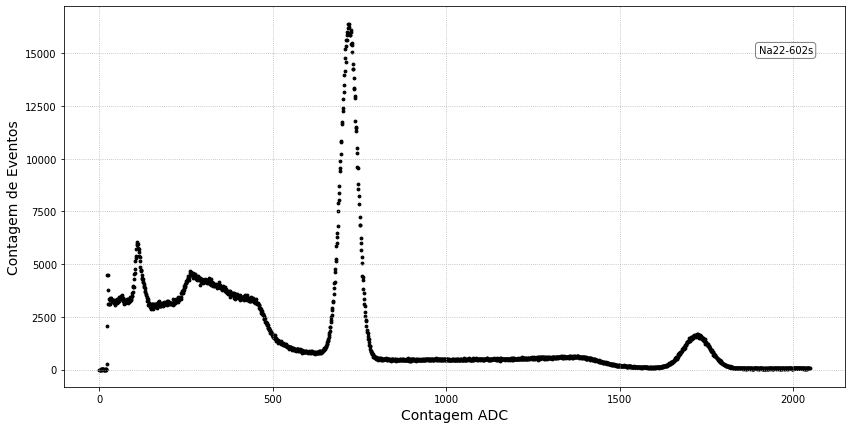

In [173]:
dataNa22 = pd.read_table('Na22.tsv', skiprows=18)

fig, ax = plt.subplots(figsize=(14,7))
plt.scatter(dataNa22['Chan'], dataNa22['Counts'], s=8, color='black')
plt.xlabel('Contagem ADC', fontsize='14')
plt.ylabel('Contagem de Eventos', fontsize='14')
ax.text(1900, 15000, 'Na22-602s', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
plt.savefig('Na22.png', transparent = True)
plt.grid(linestyle='dotted')

###1.1. Gráficos seção de área do Sódio 22

Para que os gráficos abaixo fossem feitos, pegamos pontos ao redor dos picos de modo que não fosse considerado a calda, afinal caso isso tivesse sido feito teriamos que escrever duas gaussianas para cada pico.

In [174]:
print(dataNa22.loc[500:900].nlargest(3, 'Counts'),'\n')
print(dataNa22.loc[500:900]['Counts'].idxmax())
peak1Na22 = dataNa22.iloc[dataNa22.loc[500:900]['Counts'].idxmax()]['Chan']

print(dataNa22.loc[1200:1900].nlargest(3, 'Counts'),'\n')
print(dataNa22.loc[1200:1900]['Counts'].idxmax())
peak2Na22 = dataNa22.iloc[dataNa22.loc[1200:1900]['Counts'].idxmax()]['Chan']

     Chan  Unnamed: 1  Counts
721   721         NaN   16417
717   717         NaN   16414
720   720         NaN   16268 

721
      Chan  Unnamed: 1  Counts
1725  1725         NaN    1673
1723  1723         NaN    1665
1713  1713         NaN    1650 

1725


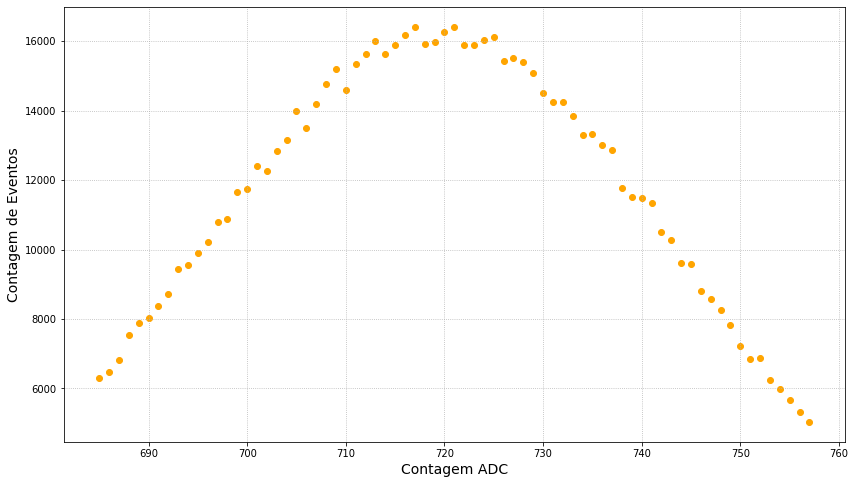

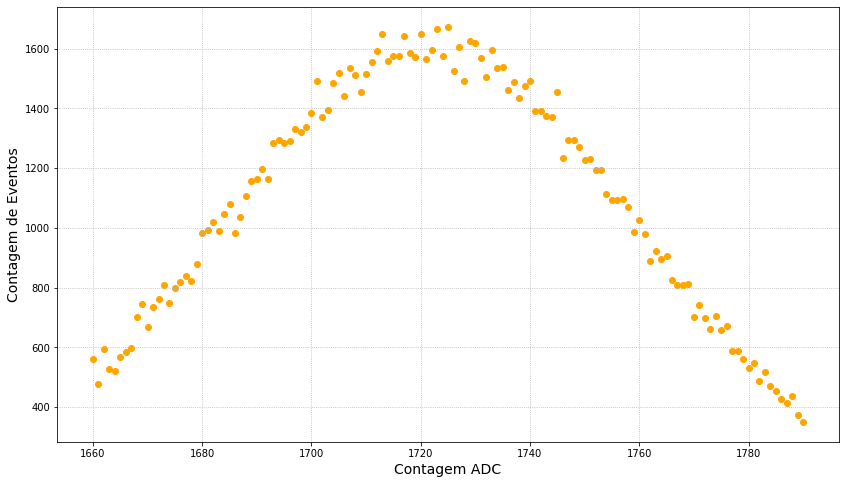

In [175]:
#First peak Na22
xdata1Na22 = dataNa22.loc[peak1Na22 - 36:peak1Na22 + 36]['Chan']
ydata1Na22 = dataNa22.loc[peak1Na22 - 36:peak1Na22 + 36]['Counts']

fig, ax = plt.subplots(figsize=(14, 8))
plt.scatter(xdata1Na22, ydata1Na22, c='orange')
plt.xlabel('Contagem ADC', fontsize='14')
plt.ylabel('Contagem de Eventos', fontsize='14')
#ax.text(750, 15950, 'Na22', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
plt.savefig('Peak1_Na22.png', transparent = True)
plt.grid(linestyle='dotted')

#Second peak Na22
xdata2Na22 = dataNa22.loc[peak2Na22 - 65:peak2Na22 + 65]['Chan']
ydata2Na22 = dataNa22.loc[peak2Na22 - 65:peak2Na22 + 65]['Counts']

fig, ax = plt.subplots(figsize=(14, 8))
plt.scatter(xdata2Na22, ydata2Na22, c='orange')
plt.xlabel('Contagem ADC', fontsize='14')
plt.ylabel('Contagem de Eventos', fontsize='14')
#ax.text(750, 15950, 'Na22', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
plt.savefig('Peak2_Na22.png', transparent = True)
plt.grid(linestyle='dotted')

###1.2. Calibração Sódio 22

#### Primeiro pico

In [176]:
def Gauss1Na22(x, A, mean, sigma): #Gaussiana para o primeiro pico
    return A * np.exp(-0.5 * np.square((x - mean) / sigma))

sigma = np.sqrt(ydata1Na22)
p0 = (1000, 720, 85) #Condições iniciais: valor máximo de y, estimativa da média, xmax - xmin

popt1Na22, pcov1Na22 = curve_fit(Gauss1Na22, xdata1Na22, ydata1Na22, sigma=sigma, p0=p0) #print A, mean, sigma

error1Na22 = [np.sqrt(pcov1Na22[i, i]) for i in np.arange(3)] #Diagonal principal da matriz

In [177]:
popt1Na22

array([16173.03753593,   719.24736626,   -24.66210316])

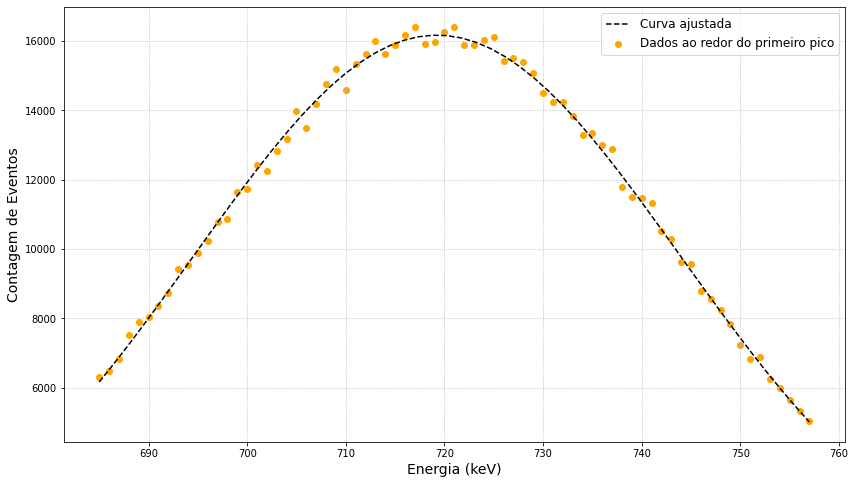

In [178]:
fig = plt.subplots(figsize=(14,8))

x_na1 = np.linspace(685, 757)
plt.plot(x_na1, Gauss1Na22(x_na1, *popt1Na22), linestyle='--', c='black', label='Curva ajustada')
plt.scatter(xdata1Na22, ydata1Na22, c='orange', label='Dados ao redor do primeiro pico')
plt.xlabel('Energia (keV)', fontsize='14')
plt.ylabel('Contagem de Eventos', fontsize='14')
plt.legend(fontsize='12')
plt.savefig('Peak1Fit_Na22.png', transparent = True)
plt.grid(linestyle='dotted')

#### Segundo Pico

In [179]:
def Gauss2Na22(x, A, mean, sigma): #Gaussiana para o segundo pico
    return A * np.exp(-0.5 * np.square((x - mean) / sigma))

sigma = np.sqrt(ydata2Na22)
p0 = (1000, 1738, 130) #Condições iniciais: valor máximo de y, estimativa da média, xmax - xmin

popt2Na22, pcov2Na22 = curve_fit(Gauss2Na22, xdata2Na22, ydata2Na22, sigma=sigma, p0=p0)

error2Na22 = [np.sqrt(pcov2Na22[i, i]) for i in np.arange(3)]

In [180]:
popt2Na22

array([1600.29666584, 1721.46403433,   39.80736386])

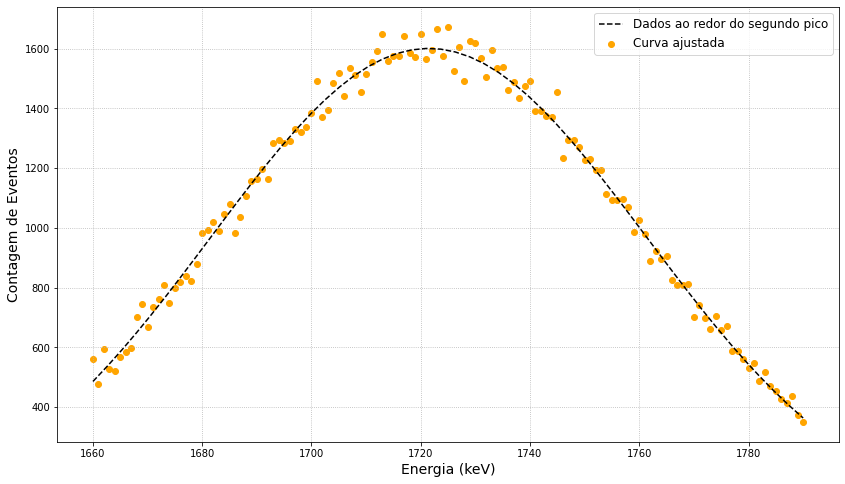

In [181]:
fig = plt.subplots(figsize=(14, 8))

x_na2 = np.linspace(1660, 1790)
plt.plot(x_na2, Gauss2Na22(x_na2, *popt2Na22), linestyle='--', c='black', label='Dados ao redor do segundo pico')
plt.scatter(xdata2Na22, ydata2Na22, c='orange', label='Curva ajustada')
plt.xlabel('Energia (keV)', fontsize='14')
plt.ylabel('Contagem de Eventos', fontsize='14')
plt.legend(fontsize='12')
plt.savefig('Peak2Fit_Na22.png', transparent = True)
plt.grid(linestyle='dotted')

## Césio 137

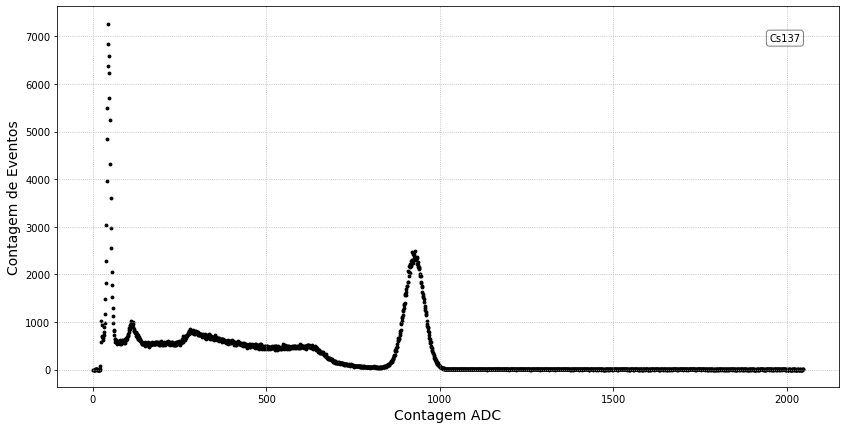

In [182]:
dataCs137 = pd.read_table('Cs137.tsv', skiprows=18)

fig, ax = plt.subplots(figsize=(14,7))
plt.scatter(dataCs137['Chan'], dataCs137['Counts'], s=8, color='black')
plt.xlabel('Contagem ADC', fontsize='14')
plt.ylabel('Contagem de Eventos', fontsize='14')
ax.text(1950, 6900, 'Cs137', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
plt.savefig('Cs137.png', transparent = True)
plt.grid(linestyle='dotted')

###2.1. Gráficos seção de área do Césio 137
Para que o gráfico abaixo fosse feito, pegamos pontos ao redor do pico de modo que não fosse considerado a calda, afinal caso isso tivesse sido feito teriamos que escrever duas gaussianas para o pico.

In [183]:
print(dataCs137.loc[800:1100].nlargest(3, 'Counts'),'\n')
print(dataCs137.loc[800:1100]['Counts'].idxmax(),'\n')
peak1Cs137 = dataCs137.iloc[dataCs137.loc[800:1100]['Counts'].idxmax()]['Chan']

     Chan  Unnamed: 1  Counts
929   929         NaN    2494
921   921         NaN    2463
927   927         NaN    2427 

929 



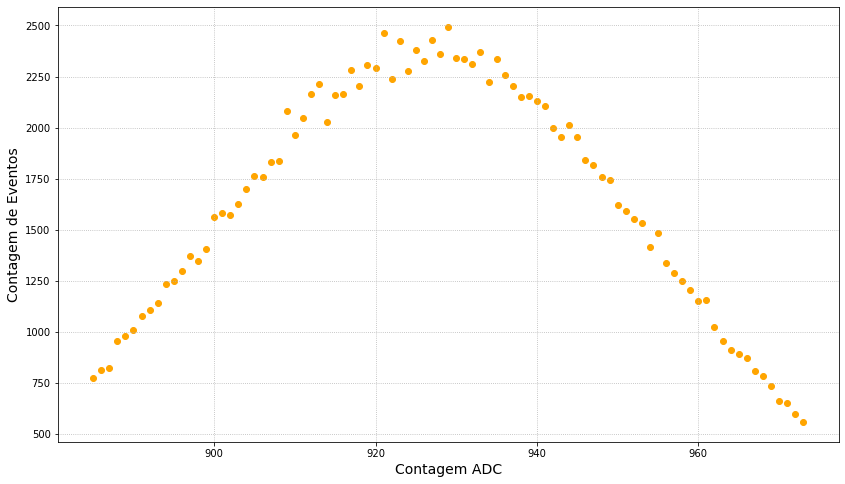

In [184]:
xdataCs137 = dataCs137.loc[peak1Cs137 - 44:peak1Cs137 + 44]['Chan']
ydataCs137 = dataCs137.loc[peak1Cs137- 44:peak1Cs137 + 44]['Counts']

fig, ax = plt.subplots(figsize=(14,8))
plt.scatter(xdataCs137, ydataCs137, c='orange')
plt.xlabel('Contagem ADC', fontsize='14')
plt.ylabel('Contagem de Eventos', fontsize='14')
#ax.text(487, 5800, 'Cs137-301s', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
plt.grid(linestyle='dotted')

#### Calibração Césio 137

In [185]:
def GaussCs137(x, A, mean, sigma): #Gaussiana para o primeiro pico
    return A * np.exp(-0.5 * np.square((x - mean) / sigma))

sigma = np.sqrt(ydataCs137)
p0 = (1000, 928, 80) #Condições iniciais: valor máximo de y, estimativa da média, xmax - xmin

poptCs137, pcovCs137 = curve_fit(GaussCs137, xdataCs137, ydataCs137, sigma=sigma, p0=p0) #print A, mean, sigma

errorCs137 = [np.sqrt(pcovCs137[i, i]) for i in np.arange(3)] 

In [186]:
poptCs137

array([2381.12049924,  926.45555533,   27.65174927])

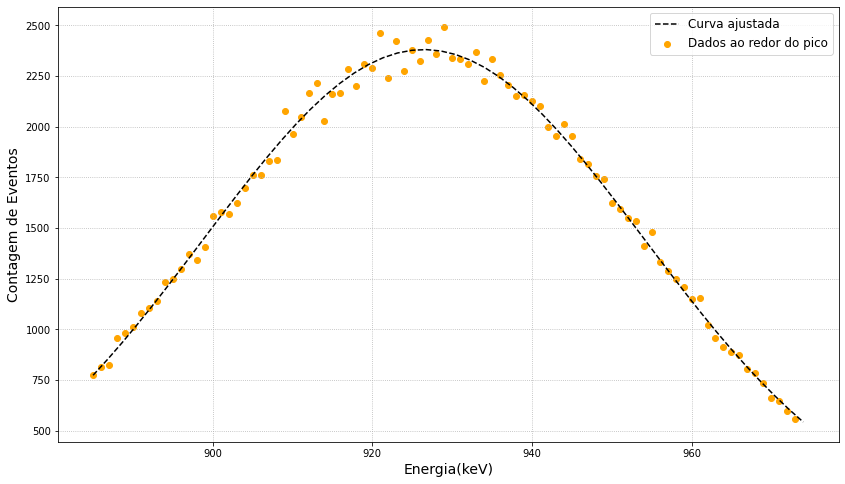

In [187]:
fig = plt.subplots(figsize=(14,8))
x_cs = np.linspace(885, 974)
plt.plot(x_cs, GaussCs137(x_cs, *poptCs137), linestyle='--', c='black', label='Curva ajustada')
plt.scatter(xdataCs137, ydataCs137, c='orange', label='Dados ao redor do pico')
plt.xlabel('Energia(keV)', fontsize='14')
plt.ylabel('Contagem de Eventos', fontsize='14')
plt.legend(fontsize='12')
plt.grid(linestyle='dotted')

## Bário 133

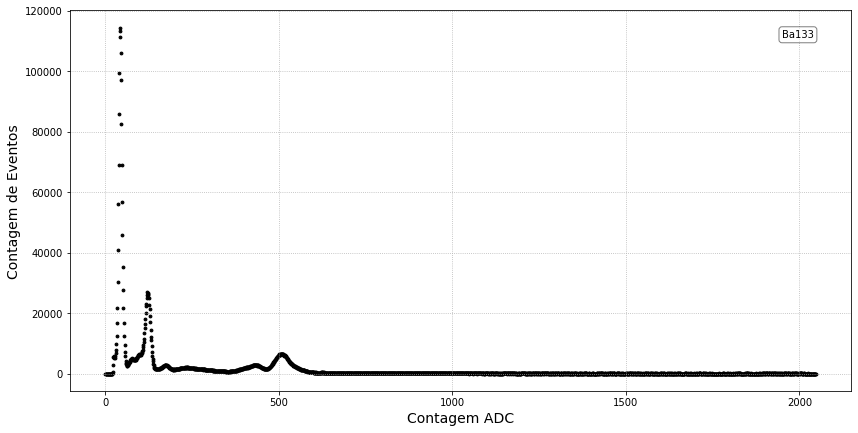

In [188]:
dataBa133 = pd.read_table('Ba133.tsv', skiprows=18)

fig, ax = plt.subplots(figsize=(14,7))
plt.scatter(dataBa133['Chan'], dataBa133['Counts'], s=8, color='black')
plt.xlabel('Contagem ADC', fontsize='14')
plt.ylabel('Contagem de Eventos', fontsize='14')
ax.text(1950, 111000, 'Ba133', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
plt.savefig('Cs137.png', transparent = True)
plt.grid(linestyle='dotted')

In [189]:
print(dataBa133.loc[100:200].nlargest(3, 'Counts'),'\n')
print(dataBa133.loc[100:200]['Counts'].idxmax())
peak1Ba133 = dataBa133.iloc[dataBa133.loc[100:200]['Counts'].idxmax()]['Chan']

print(dataBa133.loc[400:600].nlargest(3, 'Counts'),'\n')
print(dataBa133.loc[400:600]['Counts'].idxmax())
peak2Ba133 = dataBa133.iloc[dataBa133.loc[400:600]['Counts'].idxmax()]['Chan']

     Chan  Unnamed: 1  Counts
121   121         NaN   26945
123   123         NaN   26653
122   122         NaN   26417 

121
     Chan  Unnamed: 1  Counts
507   507         NaN    6590
503   503         NaN    6498
505   505         NaN    6468 

507


###1.1. Gráficos seção de área do Bário 133

Para que os gráficos abaixo fossem feitos, pegamos pontos ao redor dos picos de modo que não fosse considerado a calda, afinal caso isso tivesse sido feito teriamos que escrever duas gaussianas para cada pico.

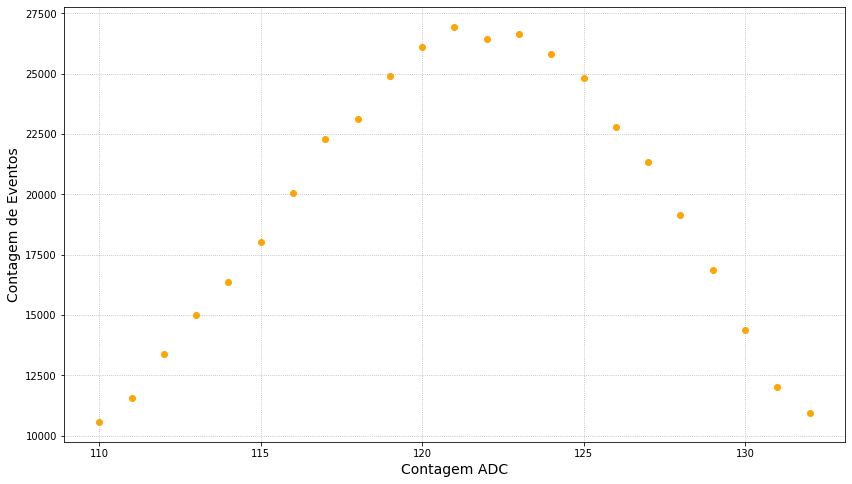

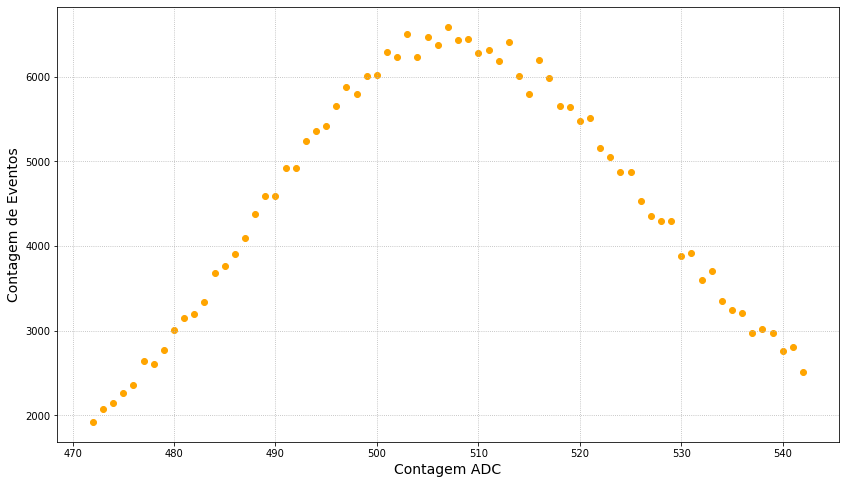

In [190]:
#First peak Ba133
xdata1Ba133 = dataBa133.loc[peak1Ba133 - 11:peak1Ba133 + 11]['Chan']
ydata1Ba133 = dataBa133.loc[peak1Ba133 - 11:peak1Ba133 + 11]['Counts']

fig, ax = plt.subplots(figsize=(14, 8))
plt.scatter(xdata1Ba133, ydata1Ba133, c='orange')
plt.xlabel('Contagem ADC', fontsize='14')
plt.ylabel('Contagem de Eventos', fontsize='14')
#ax.text(750, 15950, 'Na22', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
plt.savefig('Peak1_Ba133.png', transparent = True)
plt.grid(linestyle='dotted')

#Second peak Ba133
xdata2Ba133 = dataBa133.loc[peak2Ba133 - 35:peak2Ba133 + 35]['Chan']
ydata2Ba133 = dataBa133.loc[peak2Ba133 - 35:peak2Ba133 + 35]['Counts']

fig, ax = plt.subplots(figsize=(14, 8))
plt.scatter(xdata2Ba133, ydata2Ba133, c='orange')
plt.xlabel('Contagem ADC', fontsize='14')
plt.ylabel('Contagem de Eventos', fontsize='14')
#ax.text(750, 15950, 'Na22', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
plt.savefig('Peak2_Ba133.png', transparent = True)
plt.grid(linestyle='dotted')

### 1.2 Calibração

#### Primeiro Pico

In [ ]:
def Gauss1Na22(x, A, mean, sigma): #Gaussiana para o primeiro pico
    return A * np.exp(-0.5 * np.square((x - mean) / sigma))

sigma = np.sqrt(ydata1Na22)
p0 = (1000, 720, 85) #Condições iniciais: valor máximo de y, estimativa da média, xmax - xmin

popt1Na22, pcov1Na22 = curve_fit(Gauss1Na22, xdata1Na22, ydata1Na22, sigma=sigma, p0=p0) #print A, mean, sigma

error1Na22 = [np.sqrt(pcov1Na22[i, i]) for i in np.arange(3)] #Diagonal principal da matriz